In [1]:
# Imports
%matplotlib inline
from c3_lightcurve_functions import *
import sys
import math
import numpy as np
import pandas
from matplotlib import pyplot
from mosthosts_desi import MostHostsDesi



# To-Do

- [x] Directly port functionality from lightcurve_testing.ipynb to this notebook 
- [ ] Figure out how to manipulate pandas dataframes better - remove rows with specific values, etc
- [ ]

### Edge Cases

1. some files where the peak brightness occurs twice (maybe 190?) remove max_index[0] to find
2. some files where there is 'no data from...' at header OR footer, currently ignoring 1 line of header and footer, losing possible data
3. giga tiny filesize, index 1 only has 2 lines

In [2]:
#begin populating the dataframe that will have 
# col 1: transient name
# col 2: redshift (if exists)
# col 3: rise time
# col 4: fade time
# col 5: peak apparent magnitude
# col 6: peak absolute magnitude (converted with redshift)

#get the files
image_location = r"lightcurves/*"
filenames = sorted(glob.glob(image_location))

#create the database to be filled
transientDataFrame = pd.DataFrame(columns = ['name', 'z', 'rise time', 'fade time', 'peak apparent mag', 'peak absolute mag'])

# parse through all files, adding both possible name combinations to the dataframe
for i, filename in enumerate(filenames):
    # print(i)      #testing
    # Get the info
    # name_PTF, name_iPTF = form_transient_names(filename)
    name = filename[12:-7]
    risetime, fadetime, peak_magnitude = analyze_lightcurve(filename, plot=False)
    
    # populate the DB, once for each possible name
    newrow = pd.DataFrame({
                            'name' : name,
                            'z' : np.nan,
                            'rise time' : risetime,
                            'fade time' : fadetime,
                            'peak apparent mag' : peak_magnitude,
                            'peak absolute mag' : np.nan
                            }, index=[i])
    transientDataFrame = pd.concat([transientDataFrame, newrow])

#     newrow = pd.DataFrame({
#                                                 'name' : name_iPTF,
#                                                 'z' : np.nan,
#                                                 'rise time' : risetime,
#                                                 'fade time' : fadetime,
#                                                 'peak apparent mag' : np.nan,
#                                                 'peak absolute mag' : np.nan
#                                                 }
#     )

#     transientDataFrame = pd.concat(transientDataFrame, newrow)





In [3]:
# display the dataframe
# print(transientDataFrame.to_string())
transientDataFrame

,name,z,rise time,fade time,peak apparent mag,peak absolute mag
0,09alu,NaN,7.13,17.86,18.4538,NaN
1,09aus,NaN,-1,-1,-1,NaN
2,09bad,NaN,11.89,-12.89,20.0217,NaN
3,09bw,NaN,-1,-1,-1,NaN
4,09dfk,NaN,78.43,62.5,15.6726,NaN
...,...,...,...,...,...,...
441,17beb,NaN,-1,-1,-1,NaN
442,17jv,NaN,2.0,-3.0,19.5023,NaN
443,17wj,NaN,2.03,2.76,18.8684,NaN
444,17yw,NaN,2.0,-3.0,19.6162,NaN


In [4]:
# Finding some information about the data frame

# How many total transients did we parse?
entrycount_0 = len(transientDataFrame["name"])
print(f'The table has {entrycount_0} entries')

# How many files were too small?
toosmall_count = len(transientDataFrame[transientDataFrame['rise time'] < 0])
print(f'There were {toosmall_count} files with too few lines of data to parse.')

# #remove the bad ones
# badnames = transientDataFrame[transientDataFrame["rise time"] < 0]["name"]
# badnames = badnames.to_numpy()

# Reduce the dataframe to only transients with rise times and fade times
transientDataFrame_edited = transientDataFrame[transientDataFrame['rise time'] > 0]
transientDataFrame_edited = transientDataFrame_edited[transientDataFrame_edited['fade time'] > 0]

#reset the index
transientDataFrame_edited = transientDataFrame_edited.reset_index(drop=True)

entrycount_1 = len(transientDataFrame_edited["name"])
print(f'After removing the transients with insufficient data, we are left with {entrycount_1} entries.')






The table has 446 entries
There were 23 files with too few lines of data to parse.
After removing the transients with insufficient data, we are left with 273 entries.


In [5]:
# display the edited dataframe
# print(transientDataFrame_edited.to_string())

<Figure size 900x600 with 0 Axes>

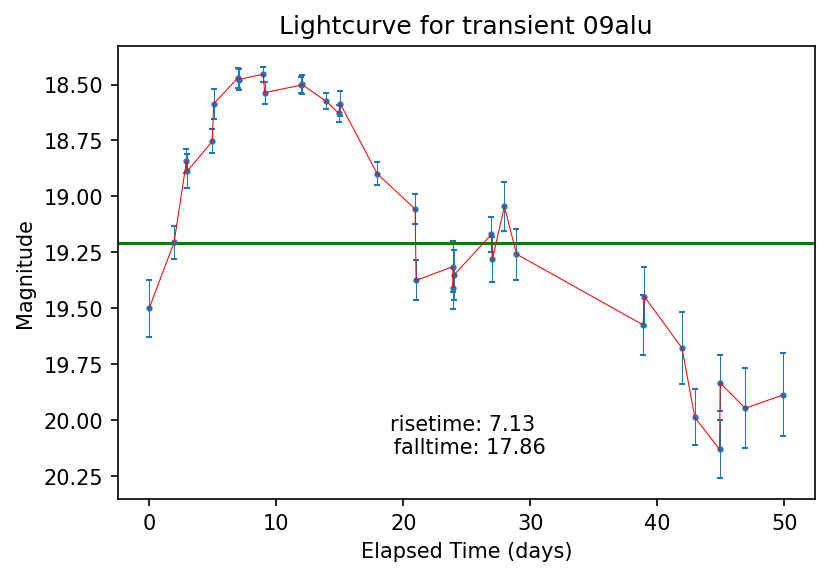

In [6]:
# Create the lightcurve for specific file indices

image_location = r"lightcurves/*"
filenames = sorted(glob.glob(image_location))

start_index = 0
end_index = 0

curr_index = start_index
for filename in filenames[start_index:end_index+1]:
    analyze_lightcurve(filename, plot=True)
    curr_index+=1


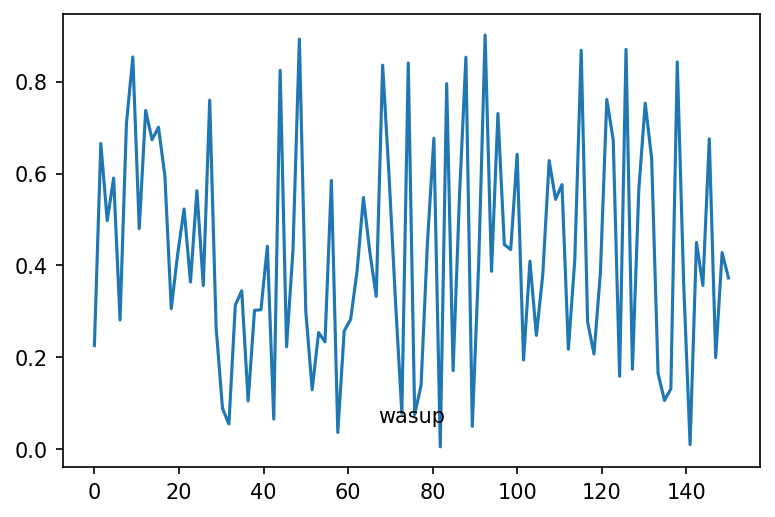

In [7]:
# testing positioning of text boxes in plt.plot

fig, ax = plt.subplots(dpi=150)

x = np.linspace(0,150, 100)
y = np.random.rand(1,100)
y = y[0,:]

plt.plot(x,y)

ax.text(.5, 0.1, "wasup", transform=ax.transAxes, ha='center')

plt.show()





In [8]:
# To actually use this, you'll need to pass a database user and password.
# See the docstring on MostHostsDesi.__init__ for more information.
# Release can be one of : daily , everest , fuji , guadalupe , fujilupe
#  (fujilupe is the union of fuji and guadalupe)
# By default, this reads mosthosts_desi_{release}.csv from the local
#   directory.  Set force_regen=True to make it rebuild that file.
subset = "daily"
mhd = MostHostsDesi( release=subset, dbuser = 'desi', dbpasswd = '5kFibers!', force_regen=False)
    

[2022-06-06 15:25:11,567 - INFO] - Loading mosthosts table...
[2022-06-06 15:25:12,790 - INFO] - ...mosthosts table loaded.
[2022-06-06 15:25:12,813 - INFO] - Read dataframes from pkl files


In [9]:
print(mhd.df.info())

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 20174 entries, ('09a', 1) to ('unknown-99', 1)
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ra            20174 non-null  float64
 1   dec           20174 non-null  float64
 2   pmra          20174 non-null  float64
 3   pmdec         20174 non-null  float64
 4   ref_epoch     20174 non-null  float64
 5   override      20174 non-null  bool   
 6   hemisphere    20174 non-null  object 
 7   sn_ra         20174 non-null  float64
 8   sn_dec        20174 non-null  float64
 9   sn_z          20174 non-null  float64
 10  program       20174 non-null  object 
 11  priority      20174 non-null  float64
 12  tns_name      20174 non-null  object 
 13  iau_name      20174 non-null  object 
 14  ptfiptf_name  20174 non-null  object 
 15  spname        20174 non-null  object 
 16  z             4534 non-null   float64
 17  zerr          4534 non-null   float64
 18  zdisp

In [10]:
def apparent_to_absolute_mag(apmag, z):
    hubble = 67.4  #km/s/Mpc
    c = 3e5
    v = z*c
    r = v / hubble * 1e6
    
    absmag = apmag - 2.5 * np.log10((r/10)**2)
    return absmag
    


for i in range(len(transientDataFrame_edited)):
    transient_name = transientDataFrame_edited.loc[i, 'name']
    transient_apmag = transientDataFrame_edited.loc[i, 'peak apparent mag']
    z = mhd.df.loc[transient_name]['z'].to_numpy()
    if len(z)>1:
        z = z[0]
    
    if z:
        z = float(z)
        absmag = apparent_to_absolute_mag(transient_apmag, z)
        transientDataFrame_edited.loc[i, 'peak absolute mag'] = absmag
    else:
        z = -1
        
        
    # print(z)
    transientDataFrame_edited.loc[i, 'z'] = z

In [11]:
transientDataFrame_edited.loc[0]["name"]

'09alu'

In [12]:
transientDataFrame_edited

,name,z,rise time,fade time,peak apparent mag,peak absolute mag
0,09alu,0.074436,7.13,17.86,18.4538,-19.147415
1,09dfk,0.016157,78.43,62.5,15.6726,-18.611479
2,09dih,NaN,8.09,15.0,19.0203,NaN
3,09dnl,0.023342,15.51,18.74,16.3278,-18.755232
4,09dsy,0.013103,7.97,18.47,15.0145,-18.814587
...,...,...,...,...,...,...
268,16gzy,0.118318,13.05,9.71,19.0984,-19.509166
269,16hun,0.089829,6.92,30.33,18.7374,-19.27198
270,16ilg,0.028114,883.44,1.26,18.1211,-17.365807
271,16ph,0.046147,2.02,13.49,18.1759,-18.387139


In [13]:
transientDataFrame_edited = transientDataFrame_edited[transientDataFrame_edited['z'] > 0]
transientDataFrame_edited = transientDataFrame_edited.reset_index(drop=True)
transientDataFrame_final = transientDataFrame_edited
print(transientDataFrame_final.to_string())

       name         z rise time fade time peak apparent mag peak absolute mag
0     09alu  0.074436      7.13     17.86           18.4538        -19.147415
1     09dfk  0.016157     78.43      62.5           15.6726        -18.611479
2     09dnl  0.023342     15.51     18.74           16.3278        -18.755232
3     09dsy  0.013103      7.97     18.47           15.0145        -18.814587
4     09fma  0.031707       2.0     35.78           16.9024        -18.845676
5      09fr  0.079872      3.35      2.18           18.2271        -19.527183
6     09gjj  0.066149      5.94    702.64           18.7003        -18.644638
7     09gnm  0.096665      6.94     27.83           18.5404        -19.628259
8     09gpu  0.081973      5.08     21.37           18.5508        -19.259858
9     09hpl   0.07807      2.04     15.32           18.8692        -18.835519
10    09iag  0.062672      3.75     19.71            18.378         -18.84969
11    09idu  0.106818       2.0    124.67            19.334     

In [14]:
mhd.df

ra        dec  pmra  pmdec  ref_epoch  override  \
snname     index                                                            
09a        1      215.982879  35.185546   0.0    0.0        0.0     False   
09aa       1      173.336031  -9.411208   0.0    0.0        0.0     False   
09ab       1      140.565584  45.747937   0.0    0.0        0.0     False   
09ac       1      186.149690  47.237527   0.0    0.0        0.0     False   
09ad       1      165.777535  50.159898   0.0    0.0        0.0     False   
...                      ...        ...   ...    ...        ...       ...   
unknown-96 1      338.069036  -1.145490   0.0    0.0        0.0     False   
unknown-97 1       27.270311   0.057102   0.0    0.0        0.0     False   
           2       27.269729   0.056582   0.0    0.0        0.0     False   
unknown-98 1       52.104573  -0.048783   0.0    0.0        0.0     False   
unknown-99 1      349.432308  -1.113769   0.0    0.0        0.0     False   

                 hemisphere       sn_ra     sn_dec     sn_z   program  \
snname     index                                                        
09a        1          north  215.982747  35.184821  0.05550  PTF-iPTF   
09aa       1          south  173.336234  -9.411180  0.12000  PTF-iPTF   
09ab       1          north  140.565681  45.747841  0.17500  PTF-iPTF   
09ac       1          north  186.147399  47.237755  0.16100  PTF-iPTF   
09ad       1          north  165.777761  50.159969  0.20100  PTF-iPTF   
...                     ...         ...        ...      ...       ...   
unknown-96 1          south  338.069000  -1.145560  0.29500   SDSS_II   
unknown-97 1          south   27.270300   0.057083  0.28600   SDSS_II   
           2          south   27.270300   0.057083  0.28600   SDSS_II   
unknown-98 1          south   52.104500  -0.048528  0.30487   SDSS_II   
unknown-99 1          south  349.432000  -1.113470  0.19000   SDSS_II   

                  priority tns_name iau_name ptfiptf_name      spname  \
snname     index                                                        
09a        1           1.0     None     None       PTF09a      PTF09a   
09aa       1           1.0     None     None      PTF09aa     PTF09aa   
09ab       1           1.0     None     None      PTF09ab     PTF09ab   
09ac       1           1.0     None     None      PTF09ac     PTF09ac   
09ad       1           1.0     None     None      PTF09ad     PTF09ad   
...                    ...      ...      ...          ...         ...   
unknown-96 1           1.0     None     None         None  unknown-96   
unknown-97 1           1.0     None     None         None  unknown-97   
           2           1.0     None     None         None  unknown-97   
unknown-98 1           1.0     None     None         None  unknown-98   
unknown-99 1           1.0     None     None         None  unknown-99   

                         z      zerr  zdisp  
snname     index                             
09a        1           NaN       NaN    NaN  
09aa       1           NaN       NaN    NaN  
09ab       1           NaN       NaN    NaN  
09ac       1      0.163469  0.000044    0.0  
09ad       1           NaN       NaN    NaN  
...                    ...       ...    ...  
unknown-96 1           NaN       NaN    NaN  
unknown-97 1           NaN       NaN    NaN  
           2      0.411150  0.000055    0.0  
unknown-98 1      0.304916  0.000019    0.0  
unknown-99 1           NaN       NaN    NaN  

[20174 rows x 19 columns]

232


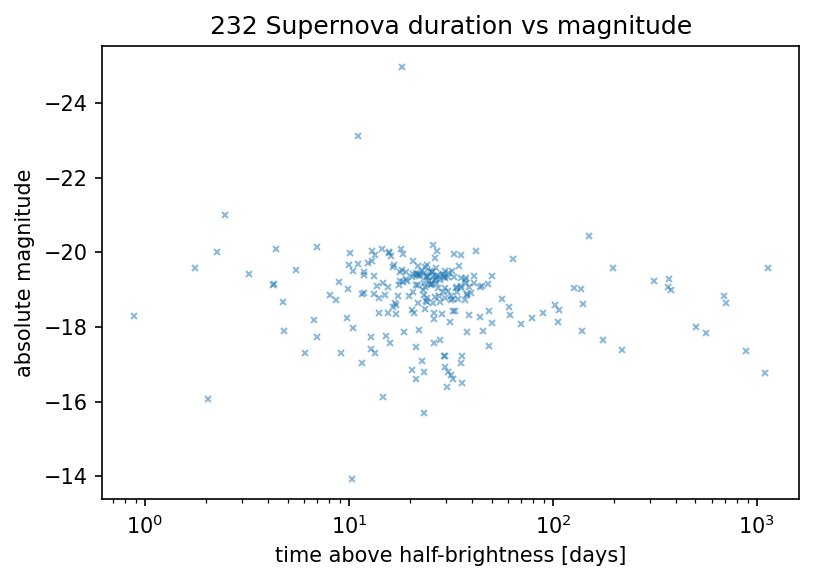

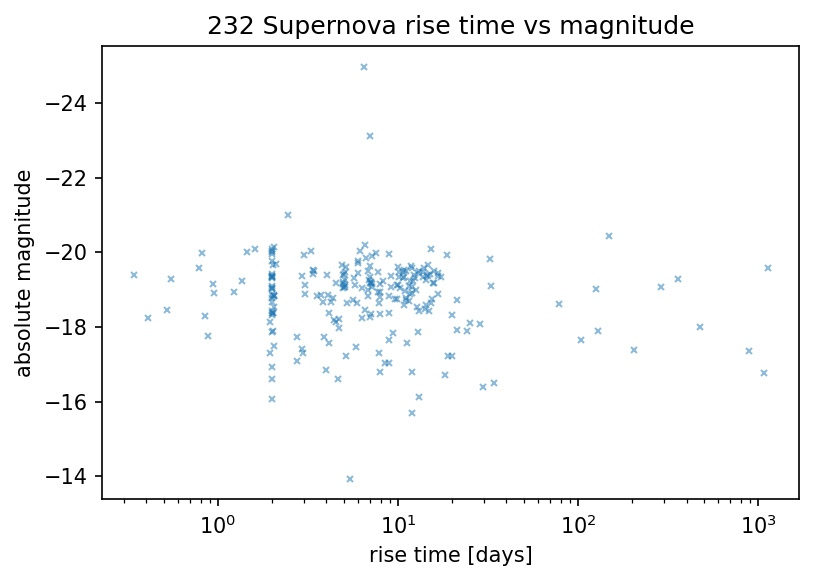

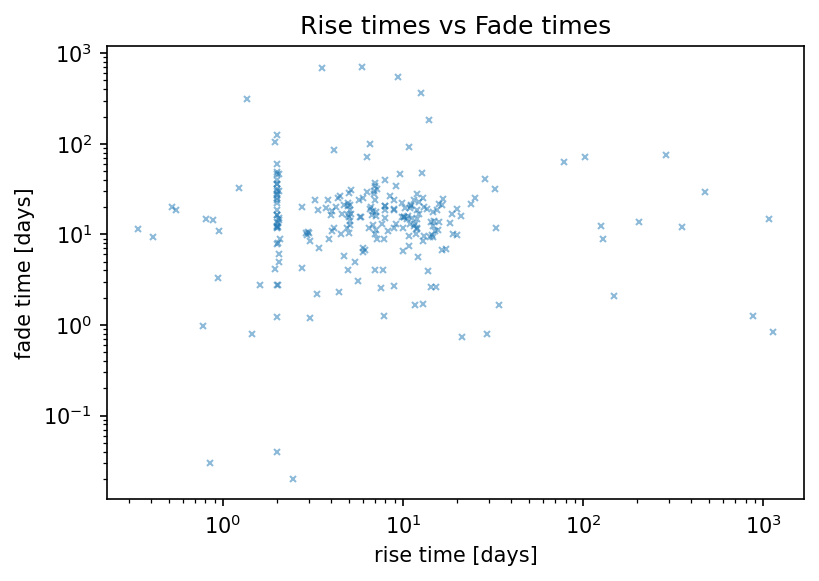

In [15]:
risetimes = transientDataFrame_final["rise time"].to_numpy()
fadetimes = transientDataFrame_final["fade time"].to_numpy()
totaltimes = risetimes + fadetimes

absolute_magnitudes = transientDataFrame_final["peak absolute mag"].to_numpy()

print(len(absolute_magnitudes))

#figure 1, duration vs magnitude
plt.figure(dpi=150)
ax1 = plt.subplot(111)
ax1.plot(totaltimes, absolute_magnitudes, marker = 'x', markersize=3, ls='none', alpha=0.5)
ax1.set_xlabel("time above half-brightness [days]")
ax1.set_ylabel("absolute magnitude")
ax1.set_title("232 Supernova duration vs magnitude")
ax1.set_xscale("log")
ax1.invert_yaxis()
plt.show()

#figure 2, rise time vs magnitude
plt.figure(dpi=150)
ax1 = plt.subplot(111)
ax1.plot(risetimes, absolute_magnitudes, marker = 'x', markersize=3, ls='none', alpha=0.5)
ax1.set_xlabel("rise time [days]")
ax1.set_ylabel("absolute magnitude")
ax1.set_title("232 Supernova rise time vs magnitude")
ax1.set_xscale("log")
ax1.invert_yaxis()
plt.show()

#Figure 3, rise time vs. fade time
plt.figure(dpi=150)
ax1 = plt.subplot(111)
ax1.plot(risetimes, fadetimes, marker = 'x', markersize=3, ls='none', alpha=0.5)
ax1.set_xlabel("rise time [days]")
ax1.set_ylabel("fade time [days]")
ax1.set_title("Rise times vs Fade times")
ax1.set_xscale("log")
ax1.set_yscale("log")

# ax1.invert_yaxis()
plt.show()

#  Ask about multiple z-values

In [16]:
# investigate the values with total time less than 10 days

#add a total time column
risetimes = transientDataFrame_final["rise time"].to_numpy()
fadetimes = transientDataFrame_final["fade time"].to_numpy()
totaltimes = risetimes + fadetimes
transientDataFrame_final["total time"] = totaltimes

#kill everything >10 total time
transDF_sub10 = transientDataFrame_final[transientDataFrame_final["total time"] < 10]

transDF_sub10 = transDF_sub10.reset_index(drop=True)
transDF_sub10


,name,z,rise time,fade time,peak apparent mag,peak absolute mag,total time
0,09fr,0.079872,3.35,2.18,18.2271,-19.527183,5.53
1,09si,0.03927,2.46,0.02,15.2133,-20.999329,2.48
2,10bmr,0.144248,0.78,0.97,19.4502,-19.587655,1.75
3,11ael,0.075886,2.0,7.84,18.6113,-19.031818,9.84
4,11ghq,0.164811,2.0,1.24,19.9058,-19.421439,3.24
5,11lmy,0.052422,4.41,2.33,18.6458,-18.194068,6.74
6,11mfy,0.068175,4.94,4.01,18.207,-19.203431,8.95
7,11opu,0.065046,2.04,6.03,18.457,-18.851416,8.07
8,12boj,0.036947,7.87,1.27,18.764,-17.316198,9.14
9,12bup,0.02346,2.0,0.04,19.0137,-16.080246,2.04


/global/u1/w/wjhohen/c3-projects/mosthosts/c3_lightcurve_functions.py:100: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(dpi=150)


<Figure size 900x600 with 0 Axes>

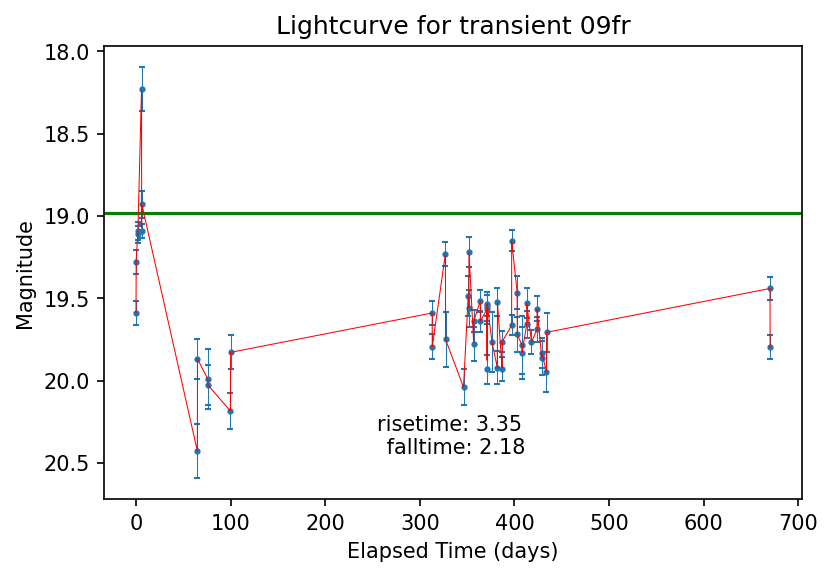

<Figure size 900x600 with 0 Axes>

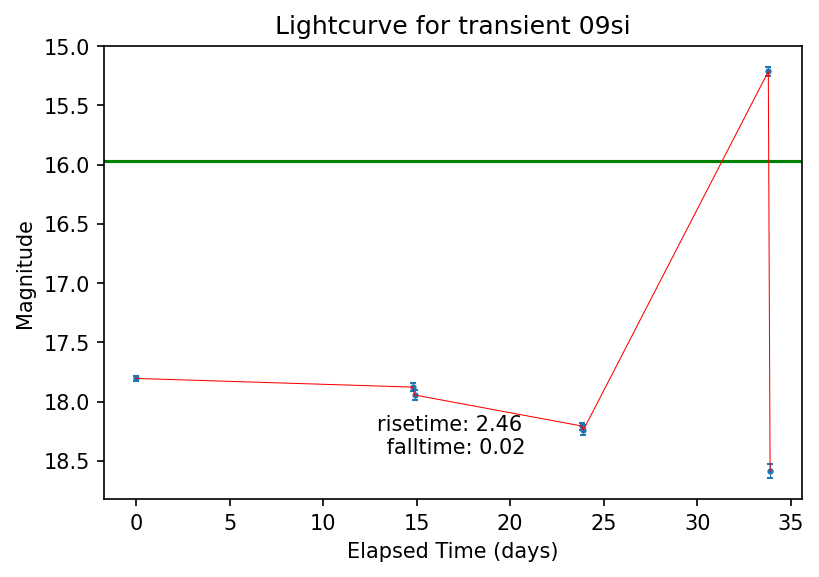

<Figure size 900x600 with 0 Axes>

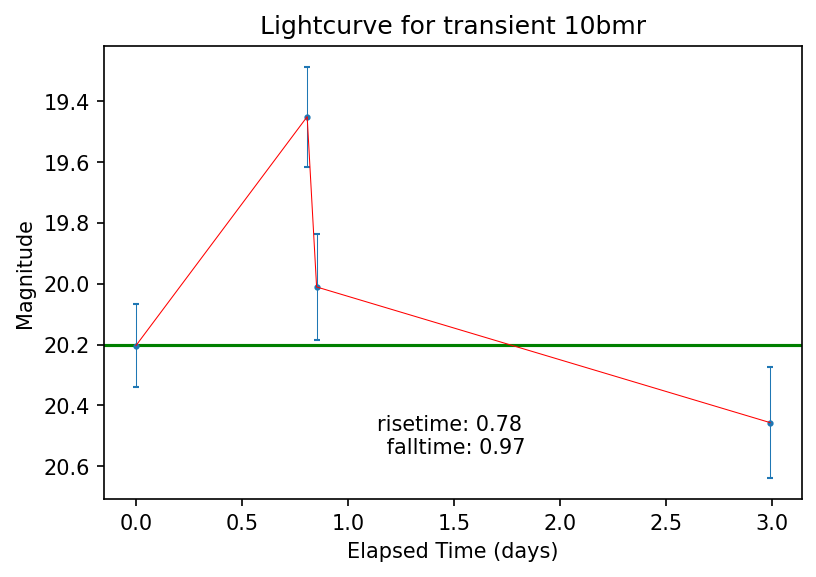

<Figure size 900x600 with 0 Axes>

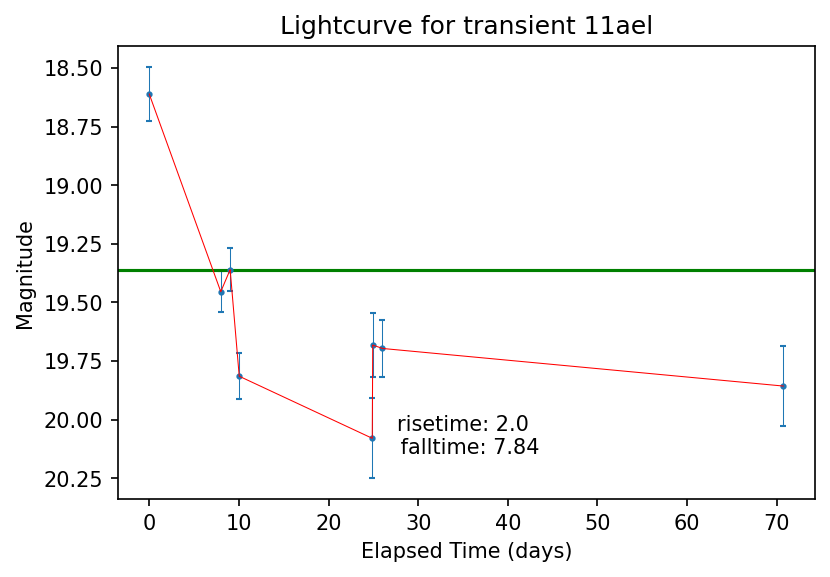

<Figure size 900x600 with 0 Axes>

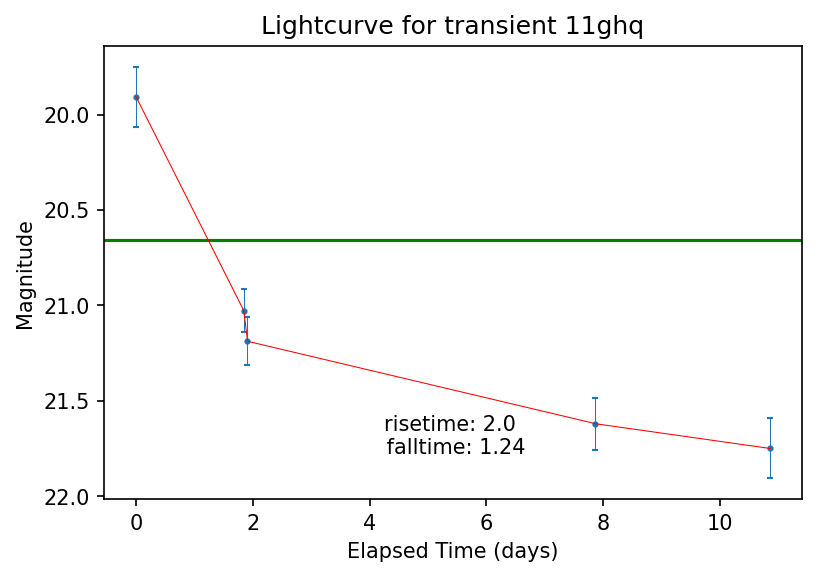

<Figure size 900x600 with 0 Axes>

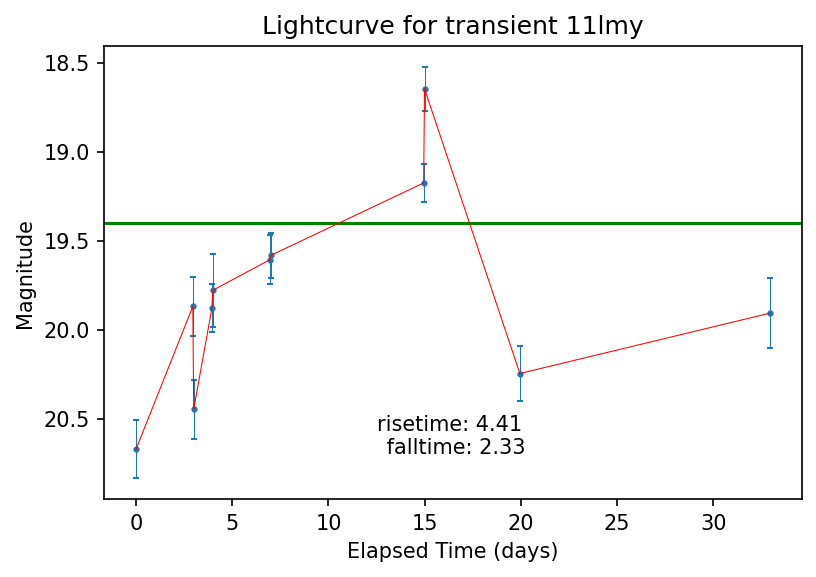

<Figure size 900x600 with 0 Axes>

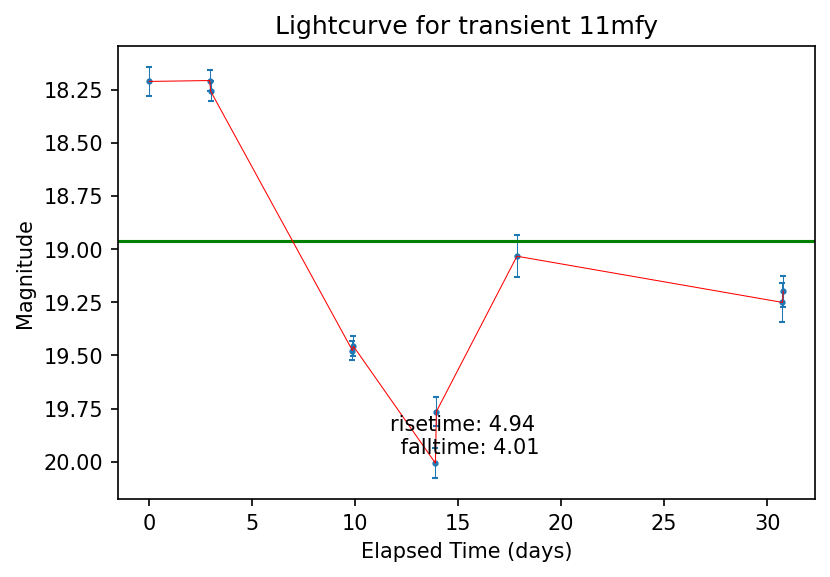

<Figure size 900x600 with 0 Axes>

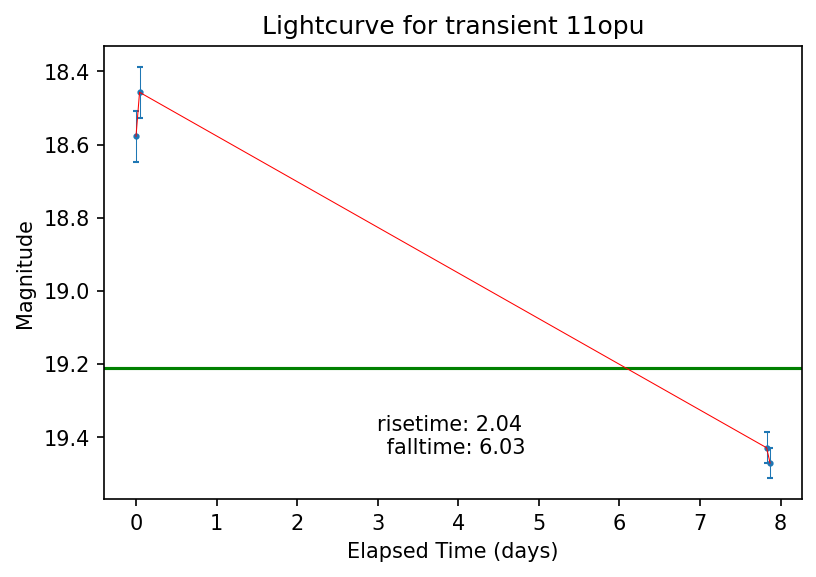

<Figure size 900x600 with 0 Axes>

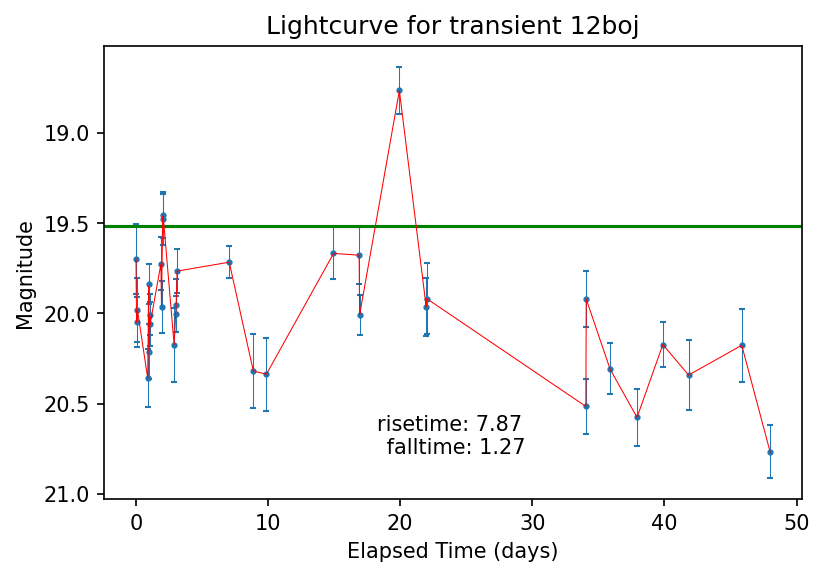

<Figure size 900x600 with 0 Axes>

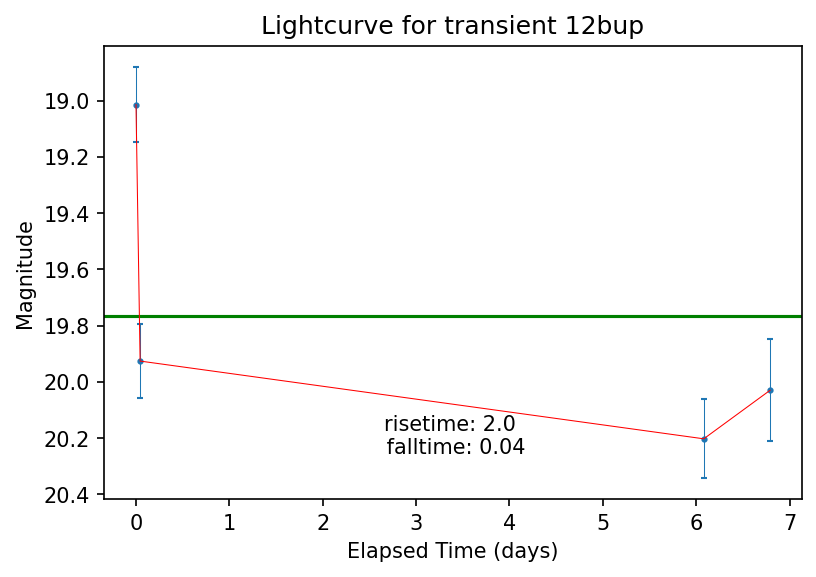

<Figure size 900x600 with 0 Axes>

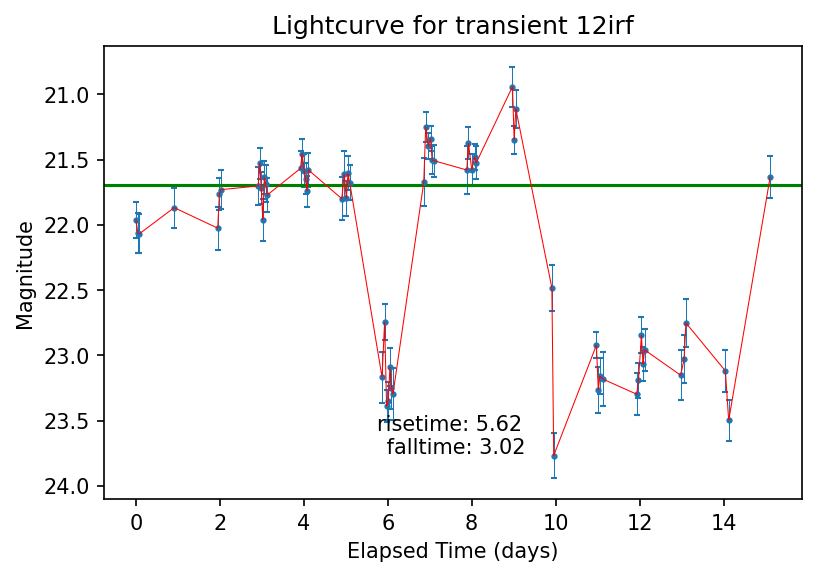

<Figure size 900x600 with 0 Axes>

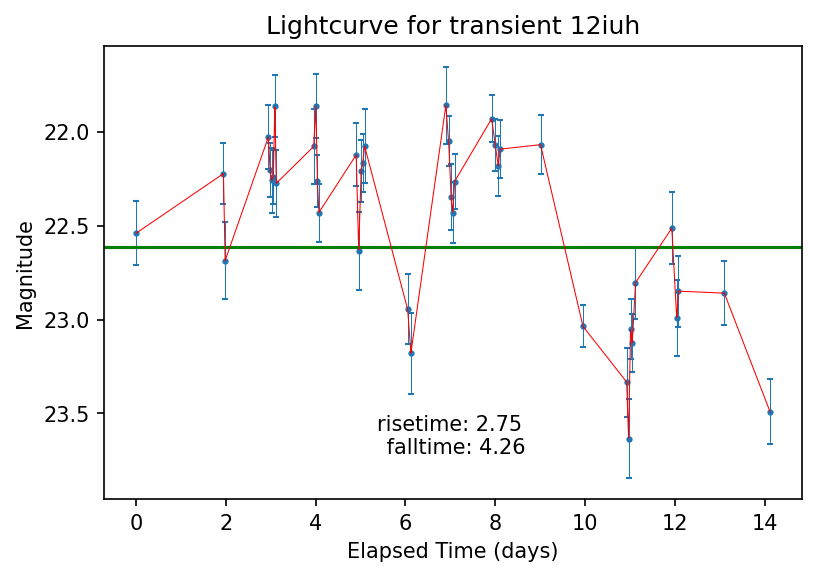

<Figure size 900x600 with 0 Axes>

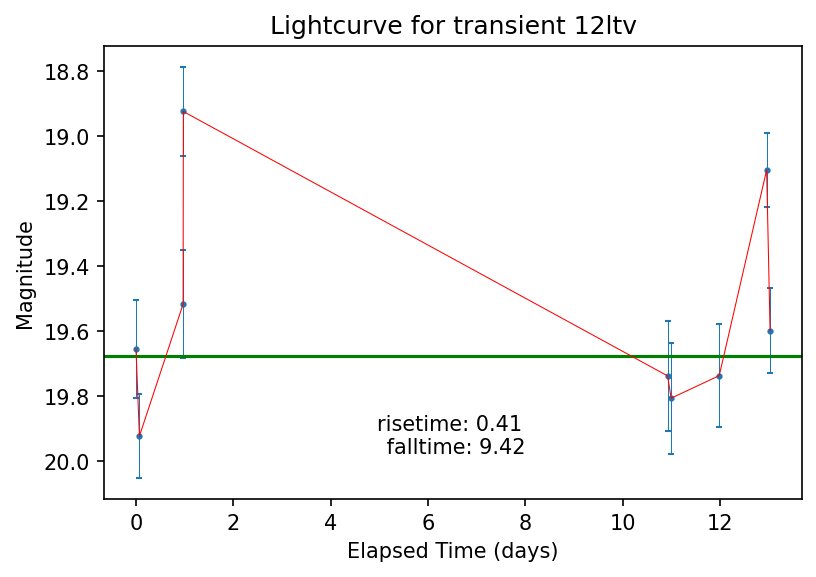

<Figure size 900x600 with 0 Axes>

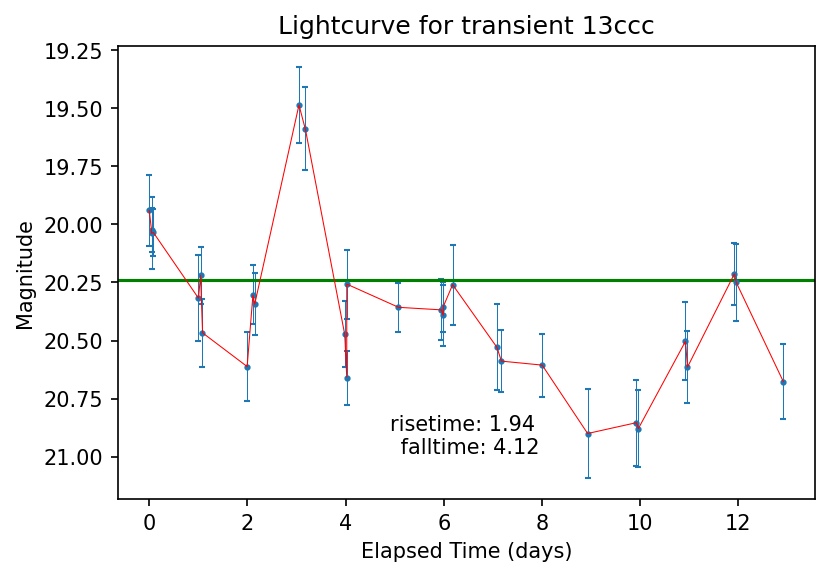

<Figure size 900x600 with 0 Axes>

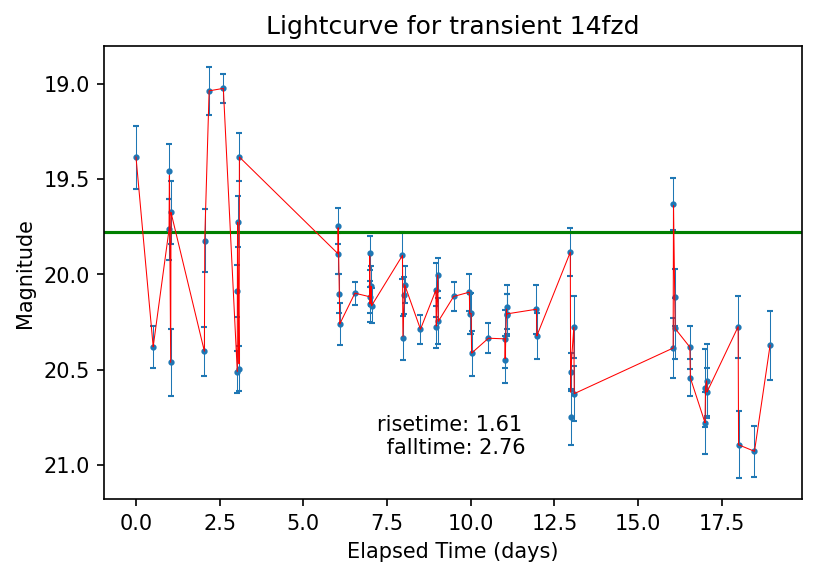

<Figure size 900x600 with 0 Axes>

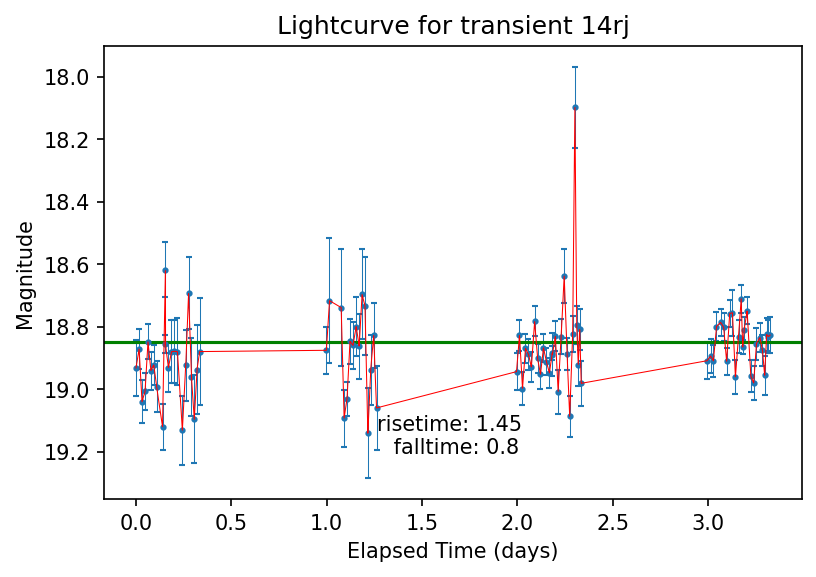

<Figure size 900x600 with 0 Axes>

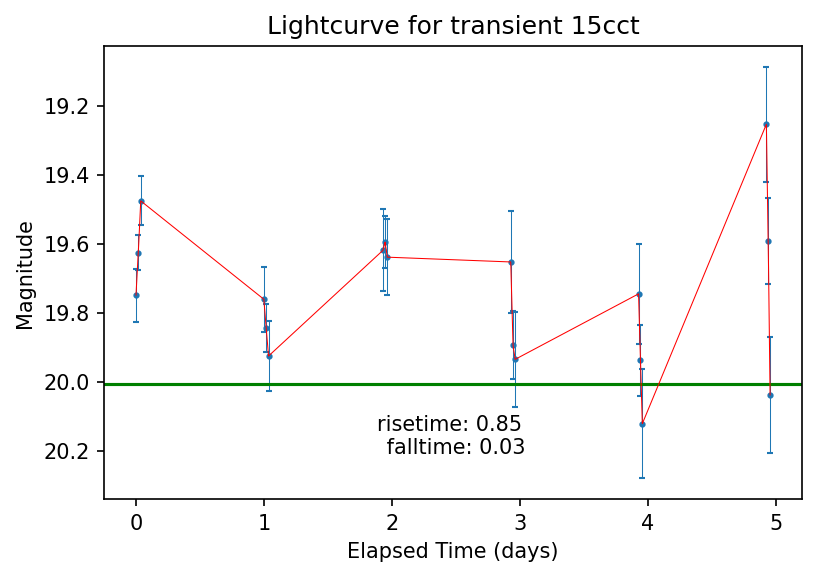

<Figure size 900x600 with 0 Axes>

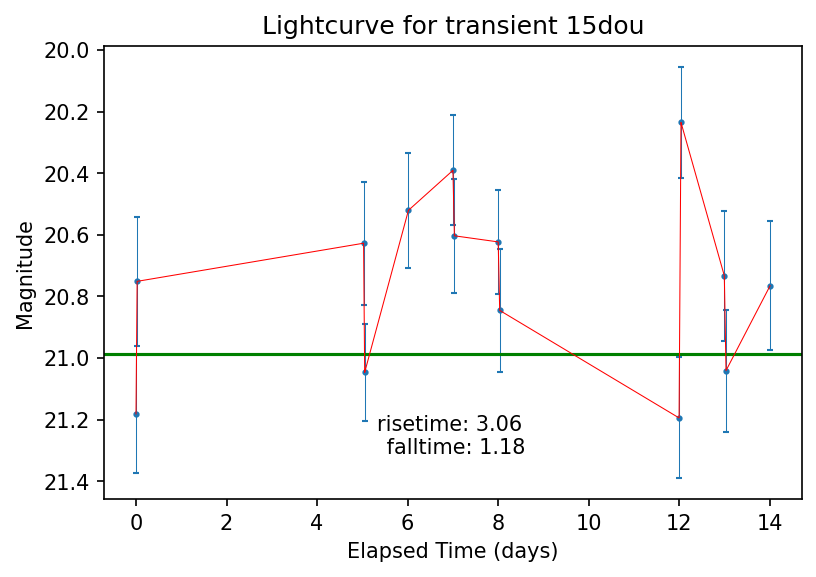

<Figure size 900x600 with 0 Axes>

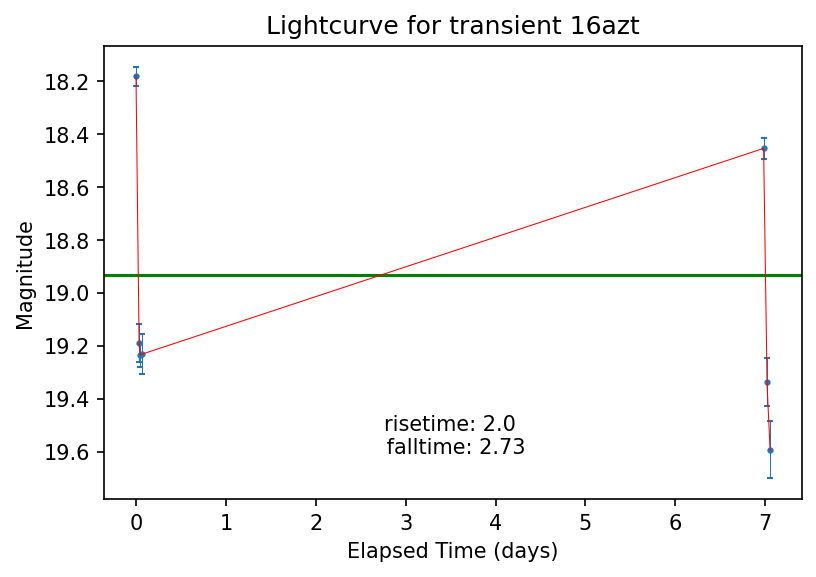

<Figure size 900x600 with 0 Axes>

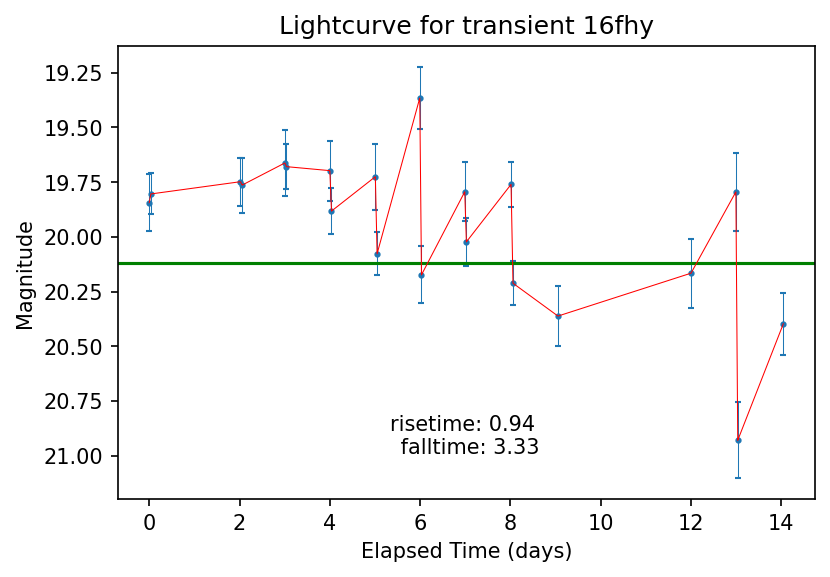

<Figure size 900x600 with 0 Axes>

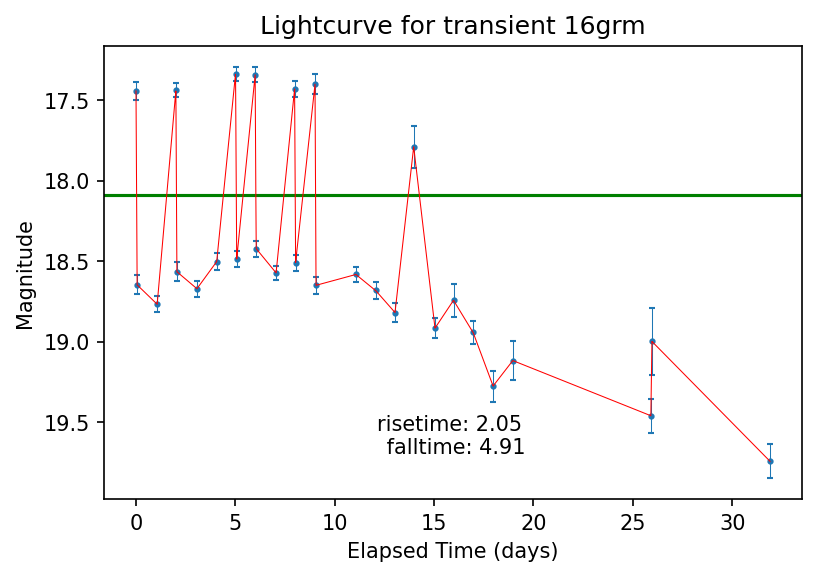

<Figure size 900x600 with 0 Axes>

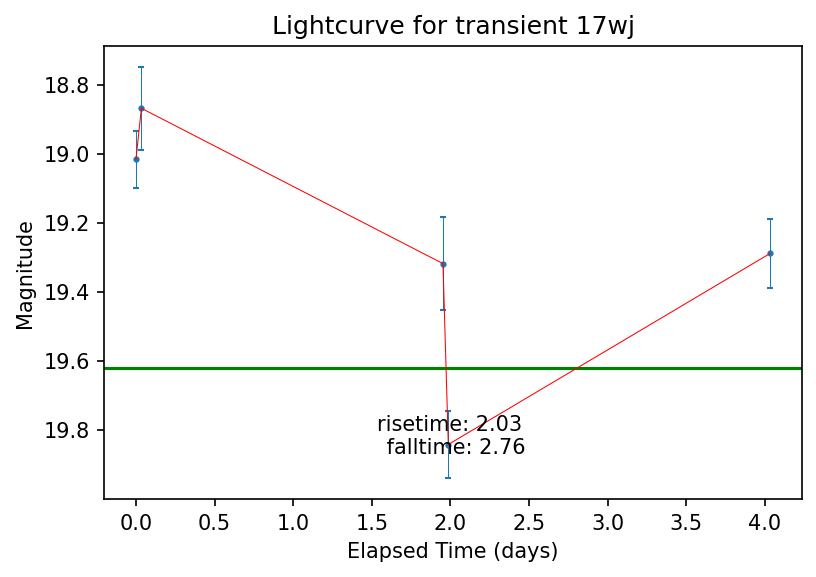

In [17]:
#plot the curves with sub 10 total times
# Create the lightcurve for specific file indices

good_sn_names_list = transDF_sub10['name'].to_numpy()
image_location = r"lightcurves/*"
filenames = sorted(glob.glob(image_location))




for filename in filenames:
    if filename[12:-7] in good_sn_names_list:
        analyze_lightcurve(filename, plot=True)


In [18]:
1 == any([1,0])



True

In [19]:
def apparent_to_absolute_mag(apmag, z):
    hubble = 67.4  #km/s/Mpc
    c = 3e5
    v = z*c
    r = v / hubble * 1e6
    
    absmag = apmag - 2.5 * np.log10((r/10)**2)
    return absmag

apparent_to_absolute_mag(18, 0.07)

-19.467796990993